In [3]:
import pymssql
import pandas as pd
import numpy as np
import mplfinance as mpf
from collections import defaultdict

In [4]:
def connect_sql():
    db_settings = {
        "host": "172.30.52.193",
        "port": 1433,
        "user": "sa",
        "password": "255089",
        "database": "ncudb",
        "charset": "utf8"
    }
    conn = pymssql.connect(**db_settings)
    return conn

In [12]:
def get_data(company, start, end, cursor):
    command = f"""SELECT [date],[o],[h],[l],[c],[v],[MA5],[MA10]
            FROM [dbo].[stock_price]
            WHERE [stock_code] = {company} AND date > '{start}' AND date < '{end}'"""
    cursor.execute(command)

    arr = []
    row = cursor.fetchone()
    while row:
        arr.append(row)
        row = cursor.fetchone()
    
    arr_df = pd.DataFrame(arr)
    arr_df['Date'] = pd.to_datetime(arr_df[0])
    arr_df = arr_df.sort_values(by="Date")
    arr_df = arr_df.drop(columns=[0])
    arr_df.set_index("Date", inplace=True)

    arr_df.columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'MA5', 'MA10']

    return arr_df

In [17]:
def get_turning_wave(company, start, end, cursor):
    command = f"""select end_date, end_date_price, trend
                from find_trend('{company}')
                WHERE end_date > '{start}' AND end_date < '{end}'
                ORDER BY end_date ASC
                """
    cursor.execute(command)

    arr = []
    row = cursor.fetchone()  
    while row:
        arr.append(row)
        row = cursor.fetchone()
    
    df = pd.DataFrame(arr)
    df.columns = ['date', 'close_price', 'trend']
    df.loc[:, 'date'] = pd.to_datetime(df['date'])
    
    df_result = pd.DataFrame()

    cur_trend = 0
    for idx in range(df['date'].size - 1, 0, -1):
        if df.loc[idx, 'trend'] != 0:
            cur_trend = df.loc[idx, 'trend']
            break

    cur_max_min = 0
    cur_start_day = np.nan
    for idx in range(df['date'].size - 1, -1, -1):
        if (df.loc[idx, 'trend'] != 0 and df.loc[idx, 'trend'] != cur_trend) or idx == 0:
            df_tmp = pd.DataFrame([[cur_start_day, np.nan, cur_max_min, cur_trend]],
                   columns=['start_day', 'end_day', 'close_price', 'trend'])
            df_result = pd.concat([df_tmp, df_result])
            cur_trend = df.loc[idx, 'trend']
            cur_max_min = 0
        
        if cur_trend == 1:
            if df.loc[idx, 'close_price'] > cur_max_min:
                cur_max_min = df.loc[idx, 'close_price']
                cur_start_day = df.loc[idx, 'date']
        else:
            if df.loc[idx, 'close_price'] < cur_max_min or cur_max_min == 0:
                cur_max_min = df.loc[idx, 'close_price']
                cur_start_day = df.loc[idx, 'date']
    df_result.reset_index(drop=True, inplace=True)
    df_result['end_day'] = df_result['start_day'].shift()
    df_result.loc[0, 'end_day'] = df.loc[0, 'date']
    
    return df_result

In [13]:
conn = connect_sql()
cursor = conn.cursor()

company = '2330'
day_start = '20210101'
day_end = '20220228'
df = get_data(company, day_start, day_end, cursor)

[(Timestamp('2021-02-17 00:00:00'), Timestamp('2021-03-25 00:00:00')), (Timestamp('2021-03-25 00:00:00'), Timestamp('2021-04-15 00:00:00')), (Timestamp('2021-04-15 00:00:00'), Timestamp('2021-05-13 00:00:00')), (Timestamp('2021-05-13 00:00:00'), Timestamp('2021-06-15 00:00:00')), (Timestamp('2021-06-15 00:00:00'), Timestamp('2021-06-22 00:00:00')), (Timestamp('2021-06-22 00:00:00'), Timestamp('2021-07-15 00:00:00')), (Timestamp('2021-07-15 00:00:00'), Timestamp('2021-08-20 00:00:00')), (Timestamp('2021-08-20 00:00:00'), Timestamp('2021-09-06 00:00:00')), (Timestamp('2021-09-06 00:00:00'), Timestamp('2021-10-06 00:00:00')), (Timestamp('2021-10-06 00:00:00'), Timestamp('2021-11-19 00:00:00')), (Timestamp('2021-11-19 00:00:00'), Timestamp('2021-11-29 00:00:00')), (Timestamp('2021-11-29 00:00:00'), Timestamp('2022-01-17 00:00:00'))]


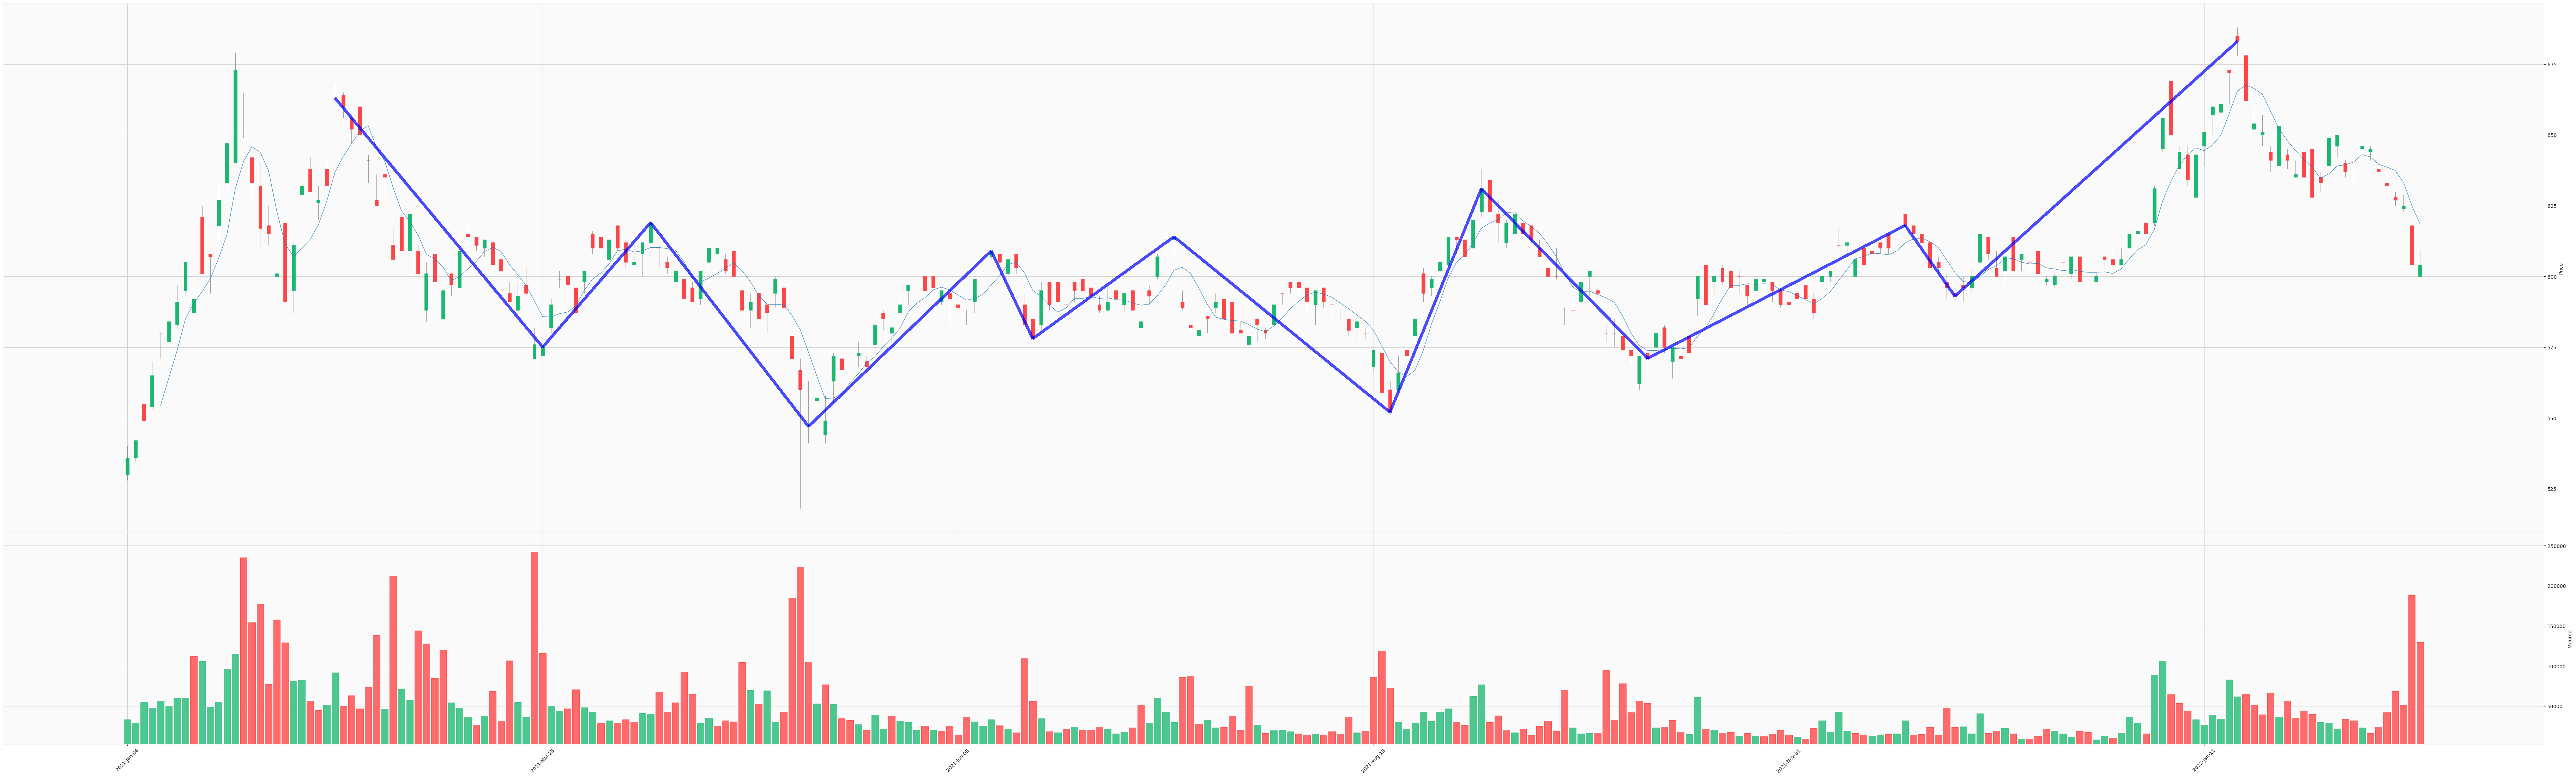

In [18]:
turning_wave = get_turning_wave(company, day_start, day_end, cursor)

datepairs_turning_wave = [(d1, d2) for d1, d2 in zip(turning_wave['end_day'], turning_wave['start_day'])]

print(datepairs_turning_wave)

mpf.plot(df, type='candle', style='yahoo', mav = (5), volume = True, figsize=(100,30),
                 tlines = [dict(tlines=datepairs_turning_wave, tline_use='close', colors='b', linewidths=5, alpha=0.7)])